In [1]:
import numpy as np
import scipy as sc
import scipy.optimize
from warnings import warn
import sparse_ir
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')


In [2]:
# Initiate fermionic and bosonic IR basis objects by using (later):
# IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
class Mesh:
    """
    Holding class for sparsely sampled imaginary time 'tau' / Matsubara frequency 'iwn' grids.
    Additionally it defines the Fourier transform via 'tau <-> l <-> wn'.
    """
    def __init__(self,IR_basis_set):
        self.IR_basis_set = IR_basis_set

        # lowest Matsubara frequency index
        self.iw0_f = np.where(self.IR_basis_set.wn_f == 1)[0][0]
        self.iw0_b = np.where(self.IR_basis_set.wn_b == 0)[0][0]

        # frequency mesh (for plotting Green function/self-energy)
        self.iwn_f = 1j * self.IR_basis_set.wn_f * np.pi * T
 
    def smpl_obj(self, statistics):
        """ Return sampling object for given statistic """
        smpl_tau = {'F': self.IR_basis_set.smpl_tau_f, 'B': self.IR_basis_set.smpl_tau_b}[statistics]
        smpl_wn  = {'F': self.IR_basis_set.smpl_wn_f,  'B': self.IR_basis_set.smpl_wn_b }[statistics]
        return smpl_tau, smpl_wn
    
    def tau_to_wn(self, statistics, obj_tau):
        """ Fourier transform from tau to iwn via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_l   = smpl_tau.fit(obj_tau, axis=0)
        obj_wn  = smpl_wn.evaluate(obj_l, axis=0)
        return obj_wn

    def wn_to_tau(self, statistics, obj_wn):
        """ Fourier transform from iwn to tau via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_l   = smpl_wn.fit(obj_wn, axis=0)
        obj_tau = smpl_tau.evaluate(obj_l, axis=0)
        return obj_tau

In [3]:
def IPTSolver(mesh, g_weiss, U):
    """
    IPT solver to calculate the impurity problem.
    Input: 
        mesh - Holding class of IR basis with sparsely sampled grids.
        g_weiss - Weiss field of the bath (\mathcal(G); cavity Green function)
                  on Matsubara frequencies iwn.
        U - Hubbard interaction strength
    """
    
    # Fourier transform to imaginary time
    gtau = mesh.wn_to_tau('F', g_weiss)

    # Self-energy in SOPT
    sigma = U**2 * gtau**3
    
    # Fourier transform back to Matsubara frequency
    sigma = mesh.tau_to_wn('F', sigma)
    return sigma

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57430/3282521825.py:6: SyntaxWarning: invalid escape sequence '\m'
  g_weiss - Weiss field of the bath (\mathcal(G); cavity Green function)


In [4]:
class DMFT_loop:
    def __init__(self,mesh, g0_loc, U, D, sfc_tol=1e-4, maxiter=20, mix=0.2,
                  verbose=True):
        
        # Set input
        self.mesh = mesh
        self.U = U
        self.t = D/2
        self.mix = mix
        self.sfc_tol = sfc_tol
        self.maxiter = maxiter
        self.verbose = verbose
        
        # Initial Green function (e.g. non-interacting)
        self.g_loc = g0_loc
        
        # Initiate Weiss field
        self.sigma = 0
        self.calc_g_weiss()
        
    def solve(self):
        for it in range(self.maxiter):
            sigma_old = self.sigma
            
            # Solve impurity problem in IPT
            sigma = IPTSolver(self.mesh, self.g_weiss, self.U)
            self.sigma = sigma*mix + self.sigma*(1-mix)
            
            # Set new Green function and Weiss field
            self.calc_g_loc()
            self.calc_g_weiss()
            
            # Check whether solution is converged
            sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))
            if self.verbose:
                print(it, sfc_check)
            if sfc_check < self.sfc_tol:
                if self.verbose:
                    print("DMFT loop converged at desired accuracy of", self.sfc_tol)
                break           
        
    def calc_g_loc(self):
        # Set interacting local Green function from Dyson's equation.
        self.g_loc = (self.g_weiss**(-1) - self.sigma)**(-1)
        
    def calc_g_weiss(self):
        # Calculate Weiss mean field of electron bath.
        self.g_weiss = (self.mesh.iwn_f - self.t**2 * self.g_loc)**(-1)
        #self.g_weiss = (self.g_loc**(-1) + self.sigma)**(-1)

In [5]:
### System parameters
D    = 2      # half bandwidth D = W/2 ; hopping t = 1 here
wmax = 2*D    # set wmax >= W = 2*D
T    = 0.1/D  # temperature
beta = 1/T    # inverse temperature
U    = 5.     # Hubbard interaction

### Numerical parameters
IR_tol  = 1e-15  # desired accuracy for l-cutoff of IR basis functions
maxiter = 300    # maximal number of DMFT convergence steps
sfc_tol = 1e-5   # desired accuracy of DMFT convergence
mix     = 0.25   # mixing factor

In [6]:
### Initialize calculation
# Set mesh
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set)

# Calculate non-interacting Green function
rho = lambda omega : 2*np.sqrt(D**2 - omega.clip(-D,D)**2)/(np.pi*D**2)
rho_l = IR_basis_set.basis_f.v.overlap(rho, -wmax, wmax)
g0_l  = -IR_basis_set.basis_f.s * rho_l
g0_loc = IR_basis_set.smpl_wn_f.evaluate(g0_l)

# Initiate DMFT loop
solver = DMFT_loop(mesh, g0_loc, U, D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=True)

# perform DMFT calculations
solver.solve()

0

1.0

1

0.45287652553561886

2

0.26510669486813254

3

0.17731829347820546

4

0.12523976244824886

5

0.09247510027206074

6

0.06995023673946282

7

0.054083263643415154

8

0.04240741732699116

9

0.03369327320014295

10

0.027029751050565157

11

0.021880655879562512

12

0.01784294863190138

13

0.014649443980923839

14

0.012098661958918159

15

0.010046464657134938

16

0.00838324613940517

17

0.007026943773431036

18

0.005914350562461535

19

0.004996809647679209

20

0.004236321545988397

21

0.003603082497468806

22

0.003073510312213293

23

0.0026288452028112425

24

0.0022540661752398963

25

0.0019370818239070426

26

0.0016681055096509662

27

0.0014391763690178015

28

0.0012437868553835999

29

0.0010765926493074575

30

0.0009331849603229271

31

0.0008099110960179278

32

0.000703732277461749

33

0.0006121104727511619

34

0.0005329178954308204

35

0.0004643643094190674

36

0.00040493837648485336

37

0.0003533601293340416

38

0.00030854229484049206

39

0.00026955868710281636

40

0.00023561827104154575

41

0.00020604379280640673

42

0.00018025410293487284

43

0.00015774947754491168

44

0.0001380993832775915

45

0.00012093224210478209

46

0.00010592683920025038

47

9.280508595644077e-05

48

8.132590496313241e-05

49

7.128004735633997e-05

50

6.248568780821363e-05

51

5.478467037959216e-05

52

4.8039301014233964e-05

53

4.2129600601760236e-05

54

3.695094734080618e-05

55

3.241204911001562e-05

56

2.843319639210661e-05

57

2.494475432895149e-05

58

2.1885859110895374e-05

59

1.9203289379333764e-05

60

1.6850487853912337e-05

61

1.4786712171033067e-05

62

1.2976297098018978e-05

63

1.1388012944086443e-05

64

9.99450730590288e-06

DMFT loop converged at desired accuracy of

1e-05

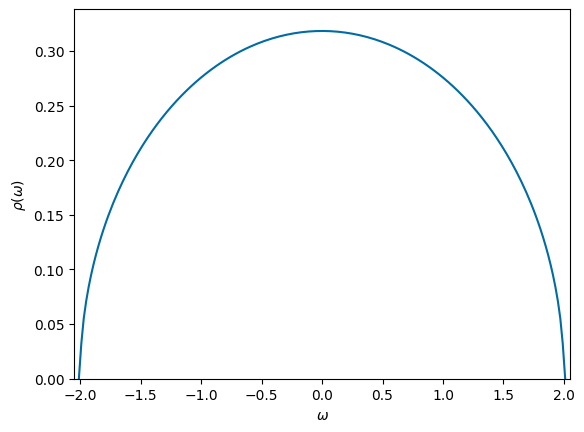

In [7]:
# Plot spectral function/density of states
omega = np.linspace(-D-0.01, D+0.01,200)
plt.plot(omega, rho(omega),'-')
ax = plt.gca()
ax.set_xlim([-D-0.05,D+0.05])
ax.set_ylim([0,2/np.pi/D+0.02])
ax.set_xlabel('$\\omega$')
ax.set_ylabel('$\\rho(\\omega)$')
plt.show()

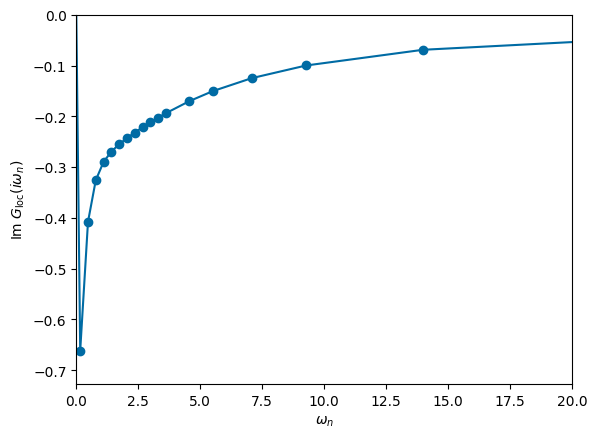

In [8]:
# plot frequency dependence of Green function
plt.plot(np.imag(mesh.iwn_f), np.imag(solver.g_loc),'-o')
ax = plt.gca()
ax.set_xlabel('$\\omega_n$')
ax.set_xlim([0,20])
ax.set_ylabel('Im $G_{\\mathrm{loc}}(i\\omega_n)$')
ax.set_ylim(ymax=0)
plt.show()

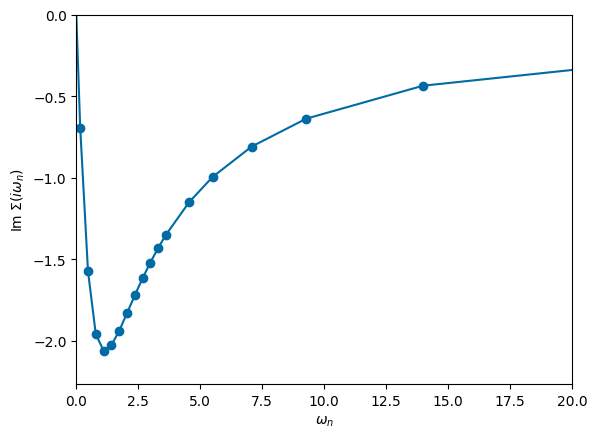

In [9]:
# plot frequency dependence of self-energy
plt.plot(np.imag(mesh.iwn_f), np.imag(solver.sigma),'-o')
ax = plt.gca()
ax.set_xlabel('$\\omega_n$')
ax.set_xlim([0,20])
ax.set_ylabel('Im $\\Sigma(i\\omega_n)$')
ax.set_ylim(ymax=0)
plt.show()

In [10]:
def CalcRenormalizationZ(solver):
    sigma = solver.sigma
    sigma_iw0 = sigma[solver.mesh.iw0_f]
    sigma_iw1 = sigma[solver.mesh.iw0_f+1]
    beta = solver.mesh.IR_basis_set.beta
    Z = 1/(1 - np.imag(sigma_iw1 - sigma_iw0)*beta/(2*np.pi))
    #Z = 1/(1 - np.imag(sigma_iw0)*beta/np.pi)
    
    # When system turns insulating, slope becomes positive/Z becomes negative -> set Z to zero then
    if Z < 0:
        Z = 0
    return Z

<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\p'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57430/583198634.py:49: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)


/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57430/4134521955.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))


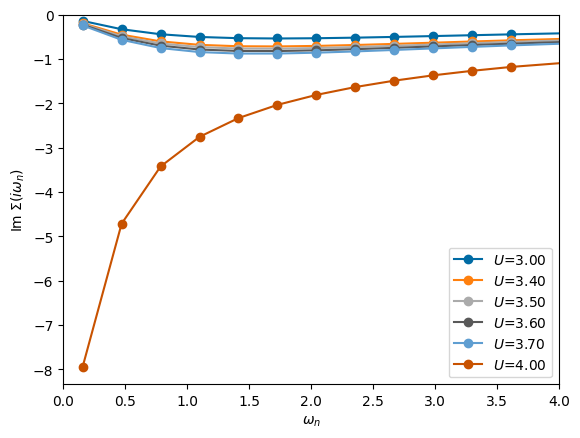

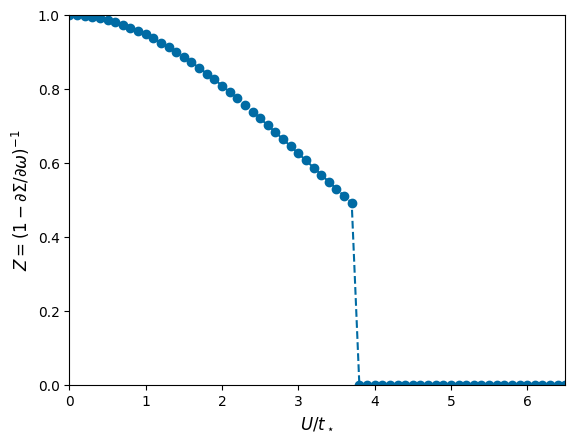

In [11]:
# Set U values as unit of t
U_min = 0
U_max = 6.5
U_num = 66
U_arr = np.linspace(U_min, U_max, U_num)
Z_arr = np.empty(U_arr.shape)

# Set new convergence parameters to achieve good convergence near the phase transition line
maxiter = 1500    # maximal number of DMFT convergence steps
sfc_tol = 1e-14   # desired accuracy of DMFT convergence


# Set mesh
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set)

# Calculate noninteracting Green function
rho = lambda omega : np.sqrt(D**2 - omega.clip(-D,D)**2)/(np.pi*D)
rho_l = IR_basis_set.basis_f.v.overlap(rho, -wmax, wmax)
g0_l  = -IR_basis_set.basis_f.s * rho_l
g0_loc = IR_basis_set.smpl_wn_f.evaluate(g0_l)


plt.figure()
for it, U in enumerate(U_arr):
    # Starting from non-interacting solution
    solver = DMFT_loop(mesh, g0_loc, U, D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
    solver.solve()    
    Z = CalcRenormalizationZ(solver)
    Z_arr[it] = Z    
        
    if it in [30, 34, 35, 36, 37, 40]:
        plt.plot(np.imag(mesh.iwn_f[mesh.iw0_f:]), np.imag(solver.sigma[mesh.iw0_f:]),'-o', label='$U$={:.2f}'.format(U))     
        
        
ax = plt.gca()
ax.set_xlabel('$\\omega_n$')
ax.set_xlim([0,4])
ax.set_ylabel('Im $\\Sigma(i\\omega_n)$')
ax.set_ylim(ymax=0)
ax.legend()

#%%%%%%%%%%%%%%%% Plot results
plt.figure()
plt.plot(U_arr, Z_arr, '--o')
ax = plt.gca()
ax.set_xlabel('$U/t_\\star$', fontsize=12)
ax.set_xlim([U_min, U_max])
ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
ax.set_ylim([0,1])
plt.show()

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57430/4052742012.py:31: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57430/4134521955.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))


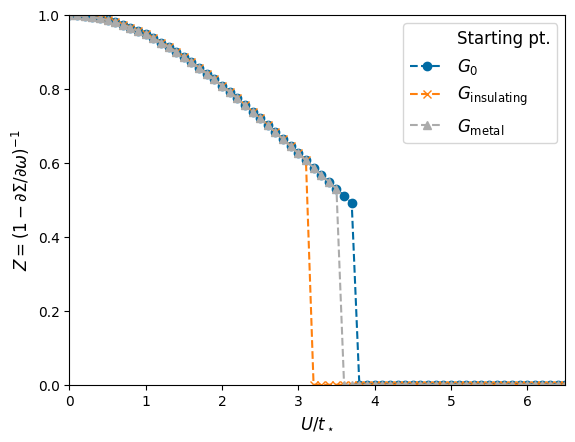

In [12]:
Z_arr_mt = np.empty(U_arr.shape)
Z_arr_in = np.empty(U_arr.shape)   

for it in range(len(U_arr)):
    if it != 0:
        solver_mt = DMFT_loop(mesh, solver_mt.g_loc, U_arr[it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
        solver_in = DMFT_loop(mesh, solver_in.g_loc, U_arr[U_num-1-it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
    else:
        solver_mt = DMFT_loop(mesh, g0_loc, U_arr[it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
        solver_in = DMFT_loop(mesh, g0_loc, U_arr[U_num-1-it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
        
    solver_mt.solve()
    Z = CalcRenormalizationZ(solver_mt)
    Z_arr_mt[it] = Z
    
    solver_in.solve()    
    Z = CalcRenormalizationZ(solver_in)
    Z_arr_in[U_num-1-it] = Z
    
        
    
#%%%%%%%%%%%%%%%% Plot results
plt.figure()
plt.plot([],[],'w',label='Starting pt.')
plt.plot(U_arr, Z_arr, '--o', label='$G_0$')
plt.plot(U_arr, Z_arr_in, '--x', label='$G_{\\mathrm{insulating}}$')
plt.plot(U_arr, Z_arr_mt, '--^', label='$G_{\\mathrm{metal}}$')
ax = plt.gca()
ax.set_xlabel('$U/t_\\star$', fontsize=12)
ax.set_xlim([U_min, U_max])
ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
ax.set_ylim([0,1])
ax.legend(fontsize=12)
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57430/927085567.py:10: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)


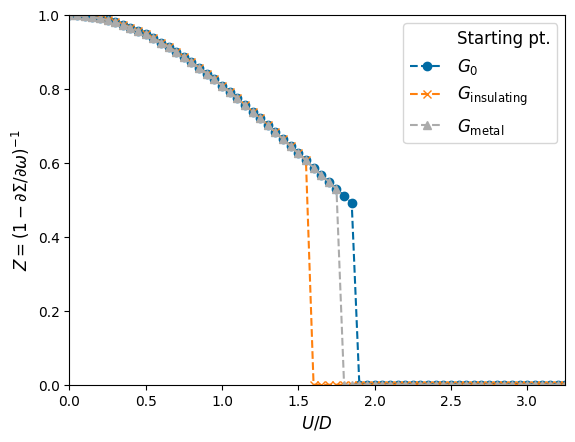

In [13]:
#%%%%%%%%%%%%%%%% Plot results
plt.figure()
plt.plot([],[],'w',label='Starting pt.')
plt.plot(U_arr/D, Z_arr, '--o', label='$G_0$')
plt.plot(U_arr/D, Z_arr_in, '--x', label='$G_{\\mathrm{insulating}}$')
plt.plot(U_arr/D, Z_arr_mt, '--^', label='$G_{\\mathrm{metal}}$')
ax = plt.gca()
ax.set_xlabel('$U/D$', fontsize=12)
ax.set_xlim([U_min/D, U_max/D])
ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
ax.set_ylim([0,1])
ax.legend(fontsize=12)
plt.show()